#Recommendation of Products based on Similar Products

##1.Data Preprocessing and feature extraction for Recommendation of Products based on Similar Products

In [11]:
%%bash
pip install stemming

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [12]:
import string
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from stemming.porter2 import stem
import networkx 
import numpy as np
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import matplotlib.pylab as plt
from IPython.display import Image
from community import community_louvain
from collections import Counter
from itertools import chain
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics.pairwise import cosine_similarity
import plotly.io as pio
pio.renderers.default = 'browser'
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Open the file to read Amazon Product Metadata

In [14]:
df = open ('/content/drive/MyDrive/BAJAJ/GNN_datasets/amazon-meta.txt', 'r', encoding='utf-8', errors= 'ignore')

#### Initialize a nested product dictionary that will hold cleaned up amazon product data. 

In [15]:
amazonProducts= {}

### Read the data from the Amazon meta information file and fill the AmazonProducts nested dictionary with features of products and extracted features of users reviews

In [16]:
(Id, ASIN, Title, Categories, Group, Copurchased, SalesRank, TotalReviews, AvgRating, DegreeCentrality, ClusteringCoeff) = ("", "", "", "", "", "", 0, 0, 0.0, 0, 0.0)

for line in df:
    line = line.strip()
    if(line.startswith("Id")): # a product block started
        Id = line[3:].strip()
    elif(line.startswith("ASIN")):
        ASIN = line[5:].strip()
    elif(line.startswith("title")):
        Title = line[6:].strip()
        Title = ' '.join(Title.split())
        continue
    elif(line.startswith("group")):
        Group = line[6:].strip()
    elif(line.startswith("salesrank")):
        SalesRank = line[10:].strip()
    elif(line.startswith("similar")):
        ls = line.split()
        no_sim = ls[1:2]
        Copurchased = ' '.join([c for c in ls[2:]])
    elif(line.startswith("categories")):
        ls = line.split()
        Categories = ' '.join((df.readline()).lower() for i in range(int(ls[1].strip())))
        Categories = re.compile('[%s]' % re.escape(string.digits+string.punctuation)).sub(' ',Categories)
        Categories = ' '.join(set(Categories.split())-set(stopwords.words("english")))
        Categories = ' '.join(stem(word) for word in Categories.split())
    elif(line.startswith("reviews")):
        ls = line.split()
        TotalReviews = ls[2].strip()
        AvgRating = ls[7].strip() # a product block ended
    elif (line==""): # write out fields to amazonProducts dictionary
        try:
            MetaData = {}
            if (ASIN != ""):
                amazonProducts[ASIN] = MetaData
            MetaData['Id'] = Id
            MetaData['Title'] = Title
            MetaData['Categories'] = ' '.join(set(Categories.split()))
            MetaData['Group'] = Group
            MetaData['Copurchased'] = Copurchased
            MetaData['SalesRank'] = int(SalesRank)
            MetaData['TotalReviews'] = int(TotalReviews)
            MetaData['AvgRating'] = float(AvgRating)
            MetaData['NoSim'] = no_sim
        except NameError:
            continue
        (Id, ASIN, Title, Categories, Group, Copurchased, SalesRank, TotalReviews, AvgRating, DegreeCentrality, ClusteringCoeff) = ("", "", "", "", "", "", 0, 0, 0.0, 0, 0.0)
df.close

<function TextIOWrapper.close>

In [17]:
for asin, metadata in amazonProducts.items():
    amazonProducts[asin]['Copurchased']= ' '.join([cp for cp in metadata['Copurchased'].split() if cp in amazonProducts.keys()])

##### Converting dictionary to dataframe

In [18]:
df = pd.DataFrame.from_dict(amazonProducts)
df = df.T

##### Helper Functions

In [19]:
def getclean(l):
    p = int(l[0]) 
    return p  

In [20]:
df['NoSim'] = df['NoSim'].apply(lambda x: getclean(x))
df['ASIN'] = df.index
df = df.set_index('Id')

In [21]:
df.to_csv('/content/drive/MyDrive/BAJAJ/GNN_datasets/Similar_Products.csv')

##2. Recommendation System of Similar Products using extracted previously

### Reading transaction data from co-purchases edgelist dataset

In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
Graphtype = nx.DiGraph()
filepath = 'drive/MyDrive/BAJAJ/GNN_datasets/amazon0601.txt' 
G = nx.read_edgelist(
    filepath,
    comments='#',
    create_using=Graphtype,
    nodetype=int
)

In [24]:
df = pd.read_csv('/content/drive/MyDrive/BAJAJ/GNN_datasets/Similar_Products.csv') 

In [25]:
df.head()

,Id,Title,Categories,Group,Copurchased,SalesRank,TotalReviews,AvgRating,NoSim,ASIN
0,0,NaN,NaN,NaN,NaN,0,0,0.0,5,0771044445
1,1,Patterns of Preaching: A Sermon Sampler,subject spiritu book sermon preach christian r...,Book,0804215715 156101074X 0687023955 0687074231 08...,396585,2,5.0,5,0827229534
2,2,Candlemas: Feast of Flames,subject book witchcraft wicca earth base spiri...,Book,0738700827 1567184960 1567182836 0738700525 07...,168596,12,4.5,5,0738700797
3,3,World War II Allied Fighter Planes Trading Cards,subject general book hobbi craft home garden,Book,NaN,1270652,1,5.0,0,0486287785
4,4,Life Application Bible Commentary: 1 and 2 Tim...,new histori guid discipleship subject testamen...,Book,0842328130 0842330313 0842328610 0842328572,631289,1,4.0,5,0842328327


In [26]:
df.isnull().sum()

Id                   0
Title             5868
Categories       28771
Group             5868
Copurchased     186985
SalesRank            0
TotalReviews         0
AvgRating            0
NoSim                0
ASIN                 0
dtype: int64

In [27]:
df['NoSim'].value_counts()

5    341088
0    165383
1     11186
2     10926
3     10390
4      9579
Name: NoSim, dtype: int64

In [28]:
nodeattrdf = df[['Title','ASIN' ,'Categories', 'Group', 'Copurchased', 'SalesRank','TotalReviews', 'AvgRating', 'NoSim']].copy()

In [29]:
nx.set_node_attributes(G, nodeattrdf.to_dict('index'))

In [30]:
G.nodes[2]

{'ASIN': '0738700797',
 'AvgRating': 4.5,
 'Categories': 'subject book witchcraft wicca earth base spiritu religion',
 'Copurchased': '0738700827 1567184960 1567182836 0738700525 0738700940',
 'Group': 'Book',
 'NoSim': 5,
 'SalesRank': 168596,
 'Title': 'Candlemas: Feast of Flames',
 'TotalReviews': 12}

####Removing nodes with no links

In [31]:
remove = [nodes for nodes in dict(G.nodes()) if len(G.nodes[nodes]) == 0] 

In [32]:
G.remove_nodes_from(remove)

In [33]:
remove[:10]

[]

In [34]:
G.number_of_nodes()

403394

####Creating an array of permissible nodes

In [35]:
n = list(G.nodes) 
n =  np.array(n)
n = np.unique(n)

In [36]:
#taking input that is allowed
tempinput = int(input())
if(tempinput in n):
  pro_id = tempinput
  print("Selected product is", pro_id)
else:
  print("Empty node has been removed from the graph!")

5
Selected product is 5


In [37]:
pro_dict = G.nodes[pro_id]

In [38]:
pro_dict #details of the product selected by the user

{'ASIN': '1577943082',
 'AvgRating': 0.0,
 'Categories': 'subject spiritu book prayerbook live devot worship busi christian religion',
 'Copurchased': '157794349X 0892749504 1577941829 0892749563',
 'Group': 'Book',
 'NoSim': 5,
 'SalesRank': 455160,
 'Title': 'Prayers That Avail Much for Business: Executive',
 'TotalReviews': 0}

####Creating a list of the ASINs of the products that are similar to the product selected

In [39]:
arr = pro_dict['Copurchased']
arr = arr.split(' ')
print(len(arr))
arr = np.array(arr)
arr

4


array(['157794349X', '0892749504', '1577941829', '0892749563'],
      dtype='<U10')

#####Helper Function to get similar product recommendations

In [40]:
def getsimilar(arr):
  indarr = []
  counter = 0
  for i in arr:
    indx = df.index[df['ASIN'] == i][0]
    if(indx in n):
      print(G.nodes[indx])
      indarr.append(indx)
    else:
      counter = counter+1
  return counter, indarr

In [41]:
counter, indarr = getsimilar(arr)
print(indarr)
print(counter,"nodes have been removed from the graph")

{'Title': 'Prayers That Avail Much for the Workplace: The Business Handbook of Scriptural Prayer', 'ASIN': '157794349X', 'Categories': 'subject spiritu invest book offic prayerbook store devot workplac prayer com worship life busi christian home religion amazon', 'Group': 'Book', 'Copurchased': '0892749504 1577941829 1577943082 0892749563', 'SalesRank': 221617, 'TotalReviews': 0, 'AvgRating': 0.0, 'NoSim': 5}
{'Title': 'Prayers That Avail Much: Three Bestselling Works Complete In One Volume, 25th Anniversary Commemorative', 'ASIN': '0892749504', 'Categories': 'subject book prayerbook inspir devot worship spiritu christian religion', 'Group': 'Book', 'Copurchased': '1577941829 0892749563 157794349X', 'SalesRank': 16962, 'TotalReviews': 16, 'AvgRating': 4.5, 'NoSim': 5}
[305321, 173362]
2 nodes have been removed from the graph


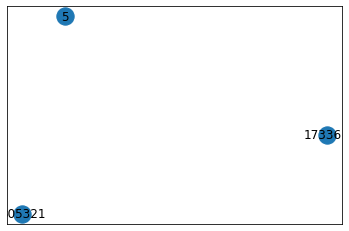

In [42]:
disparr = np.append(indarr, pro_id)
H = G.subgraph(disparr)
nx.draw_networkx(H, with_labels = True,edge_color = 'r')

In [43]:
#nx.write_gpickle(G, '/content/drive/MyDrive/GNN_datasets/G.gpickle')